# E-commerce recommender system

We are building a recommender system for an e-commerce site mainly selling clothing.

Here are the details about the products we know:
- price
- the number of reviewers
- their rating
- textual description
- name of the product (usually contains the brand name)
- category
    
We have two users, and each of them can be either be characterized by
- the initial choice of a product offered to them at registration.
- or more general characteristics explained in the below paragraph (price, reviews)
   
Users have preferences on the textual characteristics of products (description, name, category), and according to classical economics, ceteris paribus prefers products 
- that cost less
- has a lot of reviews
- with higher ratings
so we are going to set our spaces up to reflect that.

In the second part of the notebook, we introduce behavioral data in the form of events and their effects. 

Let's imagine we first examine a cold-start setup - we try to recommend items for users we know very little of. 

After introducing user behavioral data in the form of events, we look at users with some history on our site: clicked on products, bought others, etc. These are taken into account to improve the quality of the recommendations.

## Boilerplate

Let's set ourselves up to do something great.

### Installation

In [1]:
%pip install superlinked==9.38.0

### Imports and constants

In [2]:
import os
import sys
import altair as alt
import pandas as pd

from superlinked.framework.common.embedding.number_embedding import Mode
from superlinked.framework.common.schema.schema import Schema
from superlinked.framework.common.schema.event_schema import event_schema
from superlinked.framework.common.schema.schema_object import String, Integer
from superlinked.framework.common.schema.event_schema_object import (
    CreatedAtField,
    SchemaReference,
)
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
    InMemoryApp,
)
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.index.effect import Effect
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.number_space import NumberSpace

alt.renderers.enable("mimetype")
pd.set_option("display.max_colwidth", 190)

In [3]:
TOP_N = 10
storage_url = "https://storage.googleapis.com/superlinked-notebook-e-commerce-dataset"
PRODUCT_DATASET_URL = f"{storage_url}/e_commerce_notebook_recsys_product.json"
USER_DATASET_URL = f"{storage_url}/e_commerce_recsys_user.json"
EVENT_DATASET_URL = f"{storage_url}/e_commerce_recsys_event.json"

## Read and explore dataset

In [4]:
# the user preferences come from the user being prompted
# to select a product out of 3 those will be the initial preferences
# this is done in order to give somewhat personalized recommendations
user_df: pd.DataFrame = pd.read_json(USER_DATASET_URL)
user_df

,id,preference_desc,preference_category,preference_name
0,user_1,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",Women Bags,DKNY – Bucket bag
1,user_2,For cool daily looks with style and coolness. The blazer by Italian designer Daniele Alessandrini adds instant modern sophistication to any outfit.,Men Clothing Blazer,Daniele Alessandrini – Blazer


In [5]:
NROWS = int(os.getenv("NOTEBOOK_TEST_ROW_LIMIT", str(sys.maxsize)))
products_df: pd.DataFrame = (
    pd.read_json(PRODUCT_DATASET_URL)
    .reset_index()
    .rename(columns={"index": "id"})
    .head(NROWS)
)
# convert price data to int
products_df["price"] = products_df["price"].astype(int)
print(products_df.shape)
products_df.head()

(135, 9)


,id,name,description,on_sales,price,bayesian_avg,review_count,review_rating,category
0,9,Bully – Leather Jacket,"Thanks to their perfect tailoring, leather jackets by Bully are a favorite choice, not only for fashion insiders. Softest leather and modern manufacturing techniques create investment pi...",False,448,3.958763,96,4,Women Clothing Jackets
1,20,DKNY – Bag,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers dif...",False,372,3.957895,94,4,Women Bags Shoulder bags
2,25,Zanellato – Bag “Postina”,The cult bags by Italian brand Zanellato determine this season’s style. The interaction of softest leather and silver details embodies timeless chic that cannot miss in any wardrobe.,False,550,3.957447,93,4,Women Bags Handbag
3,36,Daniele Alessandrini – Vest,"These vests by Italian designer Daniele Alessandrini are edgy, cool and just perfect! The woolen suit vests in gray shades upgrade casual and office looks instantly.",False,165,3.956522,91,4,Men Clothing Jackets
4,38,DKNY – Bucket bag,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",False,372,3.956522,91,4,Women Bags


In [6]:
# we can look at the minimum and maximum values of Number-like attributes to properly set up the space
products_df[["price", "review_count", "review_rating"]].describe().loc[["min", "max"]]

,price,review_count,review_rating
min,25.0,1.0,0.0
max,1493.0,99.0,4.0


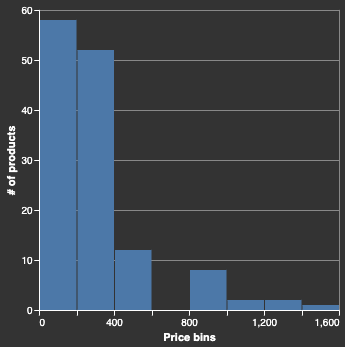

In [7]:
# but looking at the exact distribution gives even more information
alt.Chart(products_df).mark_bar().encode(
    x=alt.X("price:Q", bin=True, title="Price bins"),
    y=alt.Y("count()", title="# of products"),
)

It could make sense to set the space range to 25-1000 so that some outlier values don't distort the space.

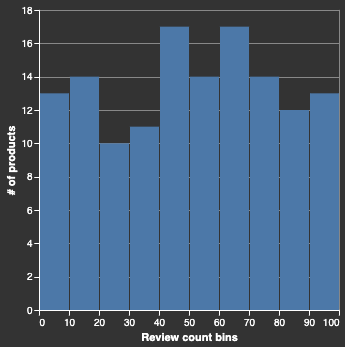

In [8]:
# evenly distributed, so no extra caution needed
alt.Chart(products_df).mark_bar().encode(
    x=alt.X("review_count:Q", bin=True, title="Review count bins"),
    y=alt.Y("count()", title="# of products"),
)

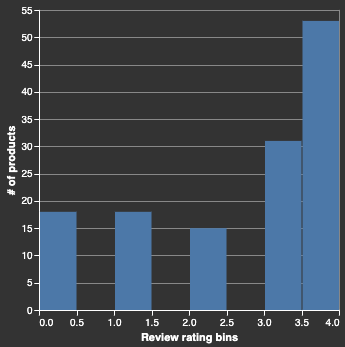

In [9]:
# relatively evenly distributed, I'd still argue for no extra caution needed
alt.Chart(products_df).mark_bar().encode(
    x=alt.X("review_rating:Q", bin=True, title="Review rating bins"),
    y=alt.Y("count()", title="# of products"),
)

## Set up Superlinked

In [10]:
# schema is the way to describe the input data flowing into our system - in a typed manner
class ProductSchema(Schema):
    description: String
    name: String
    category: String
    price: Integer
    review_count: Integer
    review_rating: Integer
    id: IdField


class UserSchema(Schema):
    preference_description: String
    preference_name: String
    preference_category: String
    id: IdField


@event_schema
class EventSchema:
    product: SchemaReference[ProductSchema]
    user: SchemaReference[UserSchema]
    event_type: String
    id: IdField
    created_at: CreatedAtField

In [11]:
# we instantiate schemas
product = ProductSchema()
user = UserSchema()
event = EventSchema()

In space definitions we describe how the inputs should be embedded in order to reflect the semantic relationships in our data.

In [12]:
# textual inputs are embedded in a text similarity space powered by a sentence_transformers model
description_space = TextSimilaritySpace(
    text=[user.preference_description, product.description],
    model="sentence-transformers/all-distilroberta-v1",
)
name_space = TextSimilaritySpace(
    text=[user.preference_name, product.name],
    model="sentence-transformers/all-distilroberta-v1",
)
category_space = TextSimilaritySpace(
    text=[user.preference_category, product.category],
    model="sentence-transformers/all-distilroberta-v1",
)

# NumberSpaces encode numeric input in special ways to reflect a relationship
# here we express relationships to price (lower the better), or ratings and review counts (more/higher the better)
price_space = NumberSpace(
    number=product.price, mode=Mode.MINIMUM, min_value=25, max_value=1000
)
review_count_space = NumberSpace(
    number=product.review_count, mode=Mode.MAXIMUM, min_value=0, max_value=100
)
review_rating_space = NumberSpace(
    number=product.review_rating, mode=Mode.MAXIMUM, min_value=0, max_value=4
)

In [13]:
# create the index using the defined spaces
product_index = Index(
    spaces=[
        description_space,
        name_space,
        category_space,
        price_space,
        review_count_space,
        review_rating_space,
    ]
)

In [14]:
# parse our data into the schemas - not matching column names can be conformed to schemas using the mapping parameter
product_df_parser = DataFrameParser(schema=product)
user_df_parser = DataFrameParser(
    schema=user, mapping={user.preference_description: "preference_desc"}
)

In [15]:
# setup our application
source_product: InMemorySource = InMemorySource(product, parser=product_df_parser)
source_user: InMemorySource = InMemorySource(user, parser=user_df_parser)
executor: InMemoryExecutor = InMemoryExecutor(
    sources=[source_product, source_user], indices=[product_index]
)
app: InMemoryApp = executor.run()

In [16]:
# load the actual data into our system
source_product.put([products_df])
source_user.put([user_df])

## Queries

Let's first showcase what we can do without events. We can consider this the cold-start solution.

In [17]:
# let's first define a user query that just searches with the user's preference vector
# configuration options are the importances (weights) of each input type (space)
user_query = (
    Query(
        product_index,
        weights={
            description_space: Param("description_weight"),
            name_space: Param("name_weight"),
            category_space: Param("category_weight"),
            price_space: Param("price_weight"),
            review_count_space: Param("review_count_weight"),
            review_rating_space: Param("review_rating_weight"),
        },
    )
    .find(product)
    .with_vector(user, Param("user_id"))
    .limit(Param("limit"))
)

In [18]:
# simple recommendations for our user_1
# these are only based on the initial product the user chose when first entering our site
simple_result = app.query(
    user_query,
    user_id="user_1",
    description_weight=1,
    name_weight=1,
    category_weight=1,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
    limit=TOP_N,
)

simple_result.to_pandas()

,description,name,category,price,review_count,review_rating,id,similarity_score
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",DKNY – Bucket bag,Women Bags,372,91,4,38,0.972965
1,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers dif...",DKNY – Bag,Women Bags Shoulder bags,372,94,4,20,0.897848
2,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the...,DKNY – Wallet,Women Bags Wallets,81,68,4,109,0.855014
3,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the cha...",DKNY – Laptop bag,Accessories Women,265,70,4,100,0.804718
4,"Its sleek design makes the leather bag from Michael Kors the perfect Everyday- Bag, which offers enough space for the most important essentials in the office, while traveling or shopping...",Michael Kors – Handbag “Jet Set Travel”,Women Bags Handbag,312,97,3,336,0.772255
5,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,Moschino Love – Shoulder bag,Women Bags Shoulder bags,227,85,4,56,0.761791
6,"High-quality and particularly creative handtaschens by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy m...",Gabs – Bag “Sofia”,Women Bags Shoulder bags,210,89,3,370,0.742868
7,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy molda...",Gabs – Bag “G3”,Women Bags Handbag,172,63,4,133,0.734406
8,The zip-around wallet “Langley“ isn’t only a very useful accessory with the studded details it’s also very trendy. The many practical pockets provide enough space for cash and cards. The...,Guess – Wallet “Langley“,Women Bags Wallets,73,91,4,39,0.729988
9,"The golden beauty bag from GUM by Gianni Chiarini Design is made out of 100% synthetic gum, so the little bag beard every scent. It is very practical and it can be stowed in a lot. With ...",GUM – Beauty bag,Accessories Women,48,89,3,369,0.722414


In [19]:
# we can also just give the user products that generally seem appealing
# low price, and a lot of good reviews (we can play around with the weights to tune those relationships, too)
general_result = app.query(
    user_query,
    user_id="user_1",
    description_weight=0,
    name_weight=0,
    category_weight=0,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
    limit=TOP_N,
)

general_result.to_pandas()

,description,name,category,price,review_count,review_rating,id,similarity_score
0,The zip-around wallet “Langley“ isn’t only a very useful accessory with the studded details it’s also very trendy. The many practical pockets provide enough space for cash and cards. The...,Guess – Wallet “Langley“,Women Bags Wallets,73,91,4,39,0.704051
1,"These vests by Italian designer Daniele Alessandrini are edgy, cool and just perfect! The woolen suit vests in gray shades upgrade casual and office looks instantly.",Daniele Alessandrini – Vest,Men Clothing Jackets,165,91,4,36,0.698785
2,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,Moschino Love – Shoulder bag,Women Bags Shoulder bags,227,85,4,56,0.688223
3,"The golden beauty bag from GUM by Gianni Chiarini Design is made out of 100% synthetic gum, so the little bag beard every scent. It is very practical and it can be stowed in a lot. With ...",GUM – Beauty bag,Accessories Women,48,89,3,369,0.685493
4,"Two in one: the shopper ""Audrey"" is perfect for a long business day or a shopping trip, but also for a nice evening, simply remove the small bag outside. The small bag can also be fixed ...",Guess – shopper “Audrey”,Women Bags Shopper,161,74,4,88,0.682086
5,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the...,DKNY – Wallet,Women Bags Wallets,81,68,4,109,0.676993
6,"High-quality and particularly creative handtaschens by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy m...",Gabs – Bag “Sofia”,Women Bags Shoulder bags,210,89,3,370,0.675263
7,Guess’s handtaschen “Carnivale” will add statement and color to any look. The big zip compartment with many practical inner bags and the two lateral compartments with magnetic closure of...,Guess – handtaschen “Carnivale“,Women Bags Handbag,181,70,4,101,0.674012
8,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers dif...",DKNY – Bag,Women Bags Shoulder bags,372,94,4,20,0.670178
9,"The light vests of Save the Duck keep us cozy warm. The slightly shiny surface in dark blue and slim, quilted fit create a cool look! The ultralight material folds into a small bag!",Save the Duck – Vest “Giga”,Men Clothing Jackets,111,65,4,122,0.670115


In [20]:
search_query = (
    user_query.similar(description_space.text, Param("query_text"))
    .similar(name_space.text, Param("query_text"))
    .similar(category_space.text, Param("query_text"))
)

# search results for the same user, who searched for a term generally
women_result = app.query(
    search_query,
    user_id="user_1",
    query_text="women clothing jackets",
    description_weight=1,
    name_weight=1,
    category_weight=1,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
    limit=TOP_N,
)

women_result.to_pandas()

,description,name,category,price,review_count,review_rating,id,similarity_score
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",DKNY – Bucket bag,Women Bags,372,91,4,38,0.525852
1,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers dif...",DKNY – Bag,Women Bags Shoulder bags,372,94,4,20,0.515231
2,"Thanks to their perfect tailoring, leather jackets by Bully are a favorite choice, not only for fashion insiders. Softest leather and modern manufacturing techniques create investment pi...",Bully – Leather Jacket,Women Clothing Jackets,448,96,4,9,0.510348
3,"These vests by Italian designer Daniele Alessandrini are edgy, cool and just perfect! The woolen suit vests in gray shades upgrade casual and office looks instantly.",Daniele Alessandrini – Vest,Men Clothing Jackets,165,91,4,36,0.500737
4,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the...,DKNY – Wallet,Women Bags Wallets,81,68,4,109,0.493251
5,"The down jacket by Herno completes our outfits with its quilted, shiny optic. The ultralight material makes it foldable and our favorite choice for the winter.",Herno – Down Jacket,Women Clothing Jackets,556,96,3,339,0.489653
6,The black leather leggings by Polo Ralph Lauren irradiates sophistication and status in distinctive manner. Leather patches on the leg inner side complete this elegant – cool look.,Polo Ralph Lauren – Leggings,Women Clothing Trouser,145,77,3,408,0.489326
7,"High-quality and particularly creative handtaschens by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy m...",Gabs – Bag “Sofia”,Women Bags Shoulder bags,210,89,3,370,0.485006
8,The zip-around wallet “Langley“ isn’t only a very useful accessory with the studded details it’s also very trendy. The many practical pockets provide enough space for cash and cards. The...,Guess – Wallet “Langley“,Women Bags Wallets,73,91,4,39,0.484200
9,Invicta’s casual jackets will keep you warm and stylish through the coldest winter months. The ultra- light material and rather timeless jet modern silhouette will make it your favorite ...,Invicta – Casual Jacket,Men Clothing Jackets,173,45,4,187,0.483284


In [21]:
# giving additional weight to the category space makes more women jackets category product appear
women_cat_result = app.query(
    search_query,
    user_id="user_1",
    query_text="women clothing jackets",
    description_weight=1,
    name_weight=1,
    category_weight=10,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
    limit=TOP_N,
)

women_cat_result.to_pandas()

,description,name,category,price,review_count,review_rating,id,similarity_score
0,"Thanks to their perfect tailoring, leather jackets by Bully are a favorite choice, not only for fashion insiders. Softest leather and modern manufacturing techniques create investment pi...",Bully – Leather Jacket,Women Clothing Jackets,448,96,4,9,0.449037
1,"The down jacket by Herno completes our outfits with its quilted, shiny optic. The ultralight material makes it foldable and our favorite choice for the winter.",Herno – Down Jacket,Women Clothing Jackets,556,96,3,339,0.441731
2,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",DKNY – Bucket bag,Women Bags,372,91,4,38,0.434480
3,The Down Jackets from Moncler are a reason to look forward to winter! “Chantilly” convinces us with its modern cut and shining material. Ultra stylish!,Moncler – Down Jacket “Chantilly”,Women Clothing Jackets,1062,17,4,279,0.424547
4,"The cropped jacket in fur optic of Elisabetta Franchi exudes luxurious glam with cool sophistication. The warm lining and double button closure guarantees coziness, while the cropped sle...",Elisabetta Franchi – Fur Jacket,Women Clothing Jackets,306,65,1,1176,0.420641
5,The Italian label Moncler presents modern elegant Down Coat with ultimate cult status! This model keeps you cozy and warm throughout the winter. The slightly diagonal zipper and stand-up...,Moncler – Down Coat “Joinville”,Women Clothing Jackets,1243,22,4,262,0.420278
6,This Down Coat by the Italian label Moncler feels like a warm hug and doesn’t only protect you from icy temperatures but is also a cult piece with its slim fit and cozy fur insert on the...,Moncler – Down Coat “Fabrefox”,Women Clothing Jackets,1493,39,2,916,0.418485
7,"Backpacks are celebrating their come back this season! With this trend piece from Guess you’ll be trendy at school, uni or the office. The eye catcher in black leather optic with studs i...",Guess – Backpack “Marrakech“,Women Bags,186,70,2,807,0.407277
8,The Down Jackets from Moncler are a reason to look forward to winter! “Anet” convinces us with its modern cut and shining material. Ultra stylish!,Moncler – Down jacket “Anet”,Women Clothing Jackets,943,42,4,195,0.406230
9,"The down coat by Herno completes our outfits with its matt, sleek optic. The ultralight material makes it foldable and our favorite choice for the winter.",Herno – Down Coat,Women Clothing Jackets,812,29,3,591,0.399328


In [22]:
# Let's bias towards the top-rated products
# low rated products disappear, jeans and top rated products are in the top recommendations.
# and also handbags, as user_1 has chosen a handbag when prompted for the first time
# Blending together different aspects!
women_cat_rev_results = app.query(
    search_query,
    user_id="user_1",
    query_text="women clothing jackets",
    description_weight=0,
    category_weight=10,
    name_weight=0,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=5,
    limit=TOP_N,
)

women_cat_rev_results.to_pandas()

,description,name,category,price,review_count,review_rating,id,similarity_score
0,"Thanks to their perfect tailoring, leather jackets by Bully are a favorite choice, not only for fashion insiders. Softest leather and modern manufacturing techniques create investment pi...",Bully – Leather Jacket,Women Clothing Jackets,448,96,4,9,0.441262
1,The Italian label Moncler presents modern elegant Down Coat with ultimate cult status! This model keeps you cozy and warm throughout the winter. The slightly diagonal zipper and stand-up...,Moncler – Down Coat “Joinville”,Women Clothing Jackets,1243,22,4,262,0.432711
2,The Down Jackets from Moncler are a reason to look forward to winter! “Chantilly” convinces us with its modern cut and shining material. Ultra stylish!,Moncler – Down Jacket “Chantilly”,Women Clothing Jackets,1062,17,4,279,0.430069
3,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",DKNY – Bucket bag,Women Bags,372,91,4,38,0.426677
4,"The down jacket by Herno completes our outfits with its quilted, shiny optic. The ultralight material makes it foldable and our favorite choice for the winter.",Herno – Down Jacket,Women Clothing Jackets,556,96,3,339,0.425111
5,The Down Jackets from Moncler are a reason to look forward to winter! “Anet” convinces us with its modern cut and shining material. Ultra stylish!,Moncler – Down jacket “Anet”,Women Clothing Jackets,943,42,4,195,0.406794
6,Guess’s handtaschen “Carnivale” will add statement and color to any look. The big zip compartment with many practical inner bags and the two lateral compartments with magnetic closure of...,Guess – handtaschen “Carnivale“,Women Bags Handbag,181,70,4,101,0.396897
7,"The down coat by Herno completes our outfits with its matt, sleek optic. The ultralight material makes it foldable and our favorite choice for the winter.",Herno – Down Coat,Women Clothing Jackets,812,29,3,591,0.395617
8,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy molda...",Gabs – Bag “G3”,Women Bags Handbag,172,63,4,133,0.395232
9,The zip-around wallet “Langley“ isn’t only a very useful accessory with the studded details it’s also very trendy. The many practical pockets provide enough space for cash and cards. The...,Guess – Wallet “Langley“,Women Bags Wallets,73,91,4,39,0.394442


Now fast-forward a month. Our users made some interactions on our platform. User_1 did some more, while user_2 only did some.

Let's now utilize their behavioral data, represented as events and their effects, for our two example users:

- a user interested in casual and leisure products
- a user interested in elegant products for going out and formal work occasions

In [23]:
events_df = (
    pd.read_json(EVENT_DATASET_URL)
    .reset_index()
    .rename(columns={"index": "id"})
    .head(NROWS)
)
events_df = events_df.merge(
    products_df[["id"]], left_on="product", right_on="id", suffixes=("", "r")
).drop("idr", axis=1)
events_df = events_df.assign(created_at=1715439600)

In [24]:
events_df

,id,user,product,event_type,created_at
0,0,user_1,276,clicked_on,1715439600
1,1,user_1,305,buy,1715439600
2,3,user_1,481,put_to_cart,1715439600
3,5,user_1,684,clicked_on,1715439600
4,7,user_1,966,buy,1715439600
5,8,user_1,1106,clicked_on,1715439600
6,10,user_1,1450,put_to_cart,1715439600
7,14,user_2,547,clicked_on,1715439600
8,16,user_2,665,put_to_cart,1715439600


In [25]:
# different actions show certain levels of interest
event_weights = {
    "clicked_on": 0.2,
    "buy": 1,
    "put_to_cart": 0.5,
    "removed_from_cart": -0.5,
}

# adjust the setup to events
product_index_with_events = Index(
    spaces=[
        description_space,
        category_space,
        name_space,
        price_space,
        review_count_space,
        review_rating_space,
    ],
    effects=[
        Effect(
            description_space,
            event.user,
            event_weight * event.product,
            event.event_type == event_type,
        )
        for event_type, event_weight in event_weights.items()
    ]
    + [
        Effect(
            category_space,
            event.user,
            event_weight * event.product,
            event.event_type == event_type,
        )
        for event_type, event_weight in event_weights.items()
    ]
    + [
        Effect(
            name_space,
            event.user,
            event_weight * event.product,
            event.event_type == event_type,
        )
        for event_type, event_weight in event_weights.items()
    ],
)
event_df_parser: DataFrameParser = DataFrameParser(schema=event)
source_event: InMemorySource = InMemorySource(schema=event, parser=event_df_parser)
executor_with_events: InMemoryExecutor = InMemoryExecutor(
    sources=[source_product, source_user, source_event],
    indices=[product_index_with_events],
)
app_with_events: InMemoryApp = executor_with_events.run()

In [26]:
events_df

,id,user,product,event_type,created_at
0,0,user_1,276,clicked_on,1715439600
1,1,user_1,305,buy,1715439600
2,3,user_1,481,put_to_cart,1715439600
3,5,user_1,684,clicked_on,1715439600
4,7,user_1,966,buy,1715439600
5,8,user_1,1106,clicked_on,1715439600
6,10,user_1,1450,put_to_cart,1715439600
7,14,user_2,547,clicked_on,1715439600
8,16,user_2,665,put_to_cart,1715439600


In [27]:
# for a new index, all data has to be put into the source again
source_product.put([products_df])
source_user.put([user_df])
source_event.put([events_df])

In [28]:
# a query only searching with the user's vector
# the preferences are now much more personalized thanks to the events
personalized_query = (
    Query(
        product_index_with_events,
        weights={
            description_space: Param("description_weight"),
            category_space: Param("category_weight"),
            name_space: Param("name_weight"),
            price_space: Param("price_weight"),
            review_count_space: Param("review_count_weight"),
            review_rating_space: Param("review_rating_weight"),
        },
    )
    .find(product)
    .with_vector(user, Param("user_id"))
    .limit(Param("limit"))
)

In [29]:
# with small weight on the spaces the events affected, we mainly just alter the results below position 4
general_event_result = app_with_events.query(
    personalized_query,
    user_id="user_1",
    description_weight=1,
    category_weight=1,
    name_weight=1,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
    limit=TOP_N,
)

general_event_result.to_pandas().join(
    simple_result.to_pandas(), lsuffix="", rsuffix="_base"
)[["description", "id", "description_base", "id_base"]]

,description,id,description_base,id_base
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",38,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",38
1,Philippe Model’s actual runner “Special” hits the spot with its sportive easiness. The interesting mixture of silver smooth leather and grey suede sums up perfectly with glittery details...,52,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers dif...",20
2,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers dif...",20,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the...,109
3,Philippe Model’s sneaker “Middle” hits the spot with its trendy easiness. The brown metallized leather sums up perfectly with the brown sequins on the side of the shoe. The rubber sole i...,102,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the cha...",100
4,Philippe Model’s sneaker “Lakers” turn into a must-have for this season with its sporty easiness. The white smooth leather sums up perfectly with the shiny leather details. The soft rubb...,83,"Its sleek design makes the leather bag from Michael Kors the perfect Everyday- Bag, which offers enough space for the most important essentials in the office, while traveling or shopping...",336
5,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the...,109,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,56
6,Philippe Model’s sneaker “City”: sporty easiness meets simple elegance and the sneaker turns into a must-have for this season. The interesting mixture of leather and textile sums up perf...,185,"High-quality and particularly creative handtaschens by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy m...",370
7,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the cha...",100,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy molda...",133
8,Philippe Model’s sneaker “Classic” is definitive a good and cool investment this season with its timeless elegance. The interesting mixture of beige leather and dark glitter applications...,233,The zip-around wallet “Langley“ isn’t only a very useful accessory with the studded details it’s also very trendy. The many practical pockets provide enough space for cash and cards. The...,39
9,The trendy sneaker from Lotto embodies modern sportively and urban trendiness. Chinese writings und structural details add progressiveness to the shoe. The perfect highlight for your eve...,121,"The golden beauty bag from GUM by Gianni Chiarini Design is made out of 100% synthetic gum, so the little bag beard every scent. It is very practical and it can be stowed in a lot. With ...",369


In [30]:
# with larger weight on the the event affected spaces, more totally new items appear in the TOP10
event_weighted_result = app_with_events.query(
    personalized_query,
    user_id="user_1",
    query_text="",
    description_weight=5,
    category_weight=1,
    name_weight=1,
    price_weight=1,
    review_count_weight=1,
    review_rating_weight=1,
    limit=TOP_N,
)

event_weighted_result.to_pandas().join(
    simple_result.to_pandas(), lsuffix="", rsuffix="_base"
)[["description", "id", "description_base", "id_base"]]

,description,id,description_base,id_base
0,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",38,"Urban understatement with a touch of elegance: with this bag, DKNY points towards a modern, linear aesthetic. The combination of quilted grey leather and gold colored metal hardware is c...",38
1,Philippe Model’s actual runner “Special” hits the spot with its sportive easiness. The interesting mixture of silver smooth leather and grey suede sums up perfectly with glittery details...,52,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers dif...",20
2,"With this bag DKNY is keeping real to it’s elegance based-on esthetics. The bag in light grey vintage leather with detachable, adjustable shoulder strap and double top handles offers dif...",20,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the...,109
3,Philippe Model’s sneaker “Middle” hits the spot with its trendy easiness. The brown metallized leather sums up perfectly with the brown sequins on the side of the shoe. The rubber sole i...,102,"This trendy bag from DKNY offers an optimal protection for your laptop. In the rugged leather bag in crocodile look is enough space for everything you need, from the USB stick on the cha...",100
4,Philippe Model’s sneaker “Classic” is definitive a good and cool investment this season with its timeless elegance. The interesting mixture of beige leather and dark glitter applications...,233,"Its sleek design makes the leather bag from Michael Kors the perfect Everyday- Bag, which offers enough space for the most important essentials in the office, while traveling or shopping...",336
5,Philippe Model’s sneaker “Lakers” turn into a must-have for this season with its sporty easiness. The white smooth leather sums up perfectly with the shiny leather details. The soft rubb...,83,This bag is a true key piece! The opulent golden LOVE logo on black leather optic add a typical Moschino finish to the bag. The quilted sides in nappa leather add sophistication to the bag.,56
6,With this wallet DKNY shows the extravagant part of the label. The many practical pockets provide enough space for cash and cards. The multicolored wallet in leather in snake look is the...,109,"High-quality and particularly creative handtaschens by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy m...",370
7,Philippe Model’s sneaker “City”: sporty easiness meets simple elegance and the sneaker turns into a must-have for this season. The interesting mixture of leather and textile sums up perf...,185,"High-quality and particularly creative handbags by GABS, by the Italian designer Franco Gabbrielli. A „must have” for the modern and self-confident woman. This bag is fast and easy molda...",133
8,Philippe Model’s actual runner “Tropez” hits the spot with its sportive easiness. The interesting mixture of light grey suede and white textile sums up perfectly with dark red details on...,1437,The zip-around wallet “Langley“ isn’t only a very useful accessory with the studded details it’s also very trendy. The many practical pockets provide enough space for cash and cards. The...,39
9,The handmade Runner by Philippe Model convinces in typical manner trough cool material mixes and fresh details. Golden and glittering details on the back add a relaxed glam vibe to the t...,488,"The golden beauty bag from GUM by Gianni Chiarini Design is made out of 100% synthetic gum, so the little bag beard every scent. It is very practical and it can be stowed in a lot. With ...",369


In [31]:
# and we can also bias towards cheaper products
price_result = app_with_events.query(
    personalized_query,
    user_id="user_1",
    query_text="",
    description_weight=5,
    category_weight=1,
    name_weight=1,
    price_weight=15,
    review_count_weight=1,
    review_rating_weight=1,
    limit=TOP_N,
)

price_result.to_pandas().join(
    general_event_result.to_pandas(), lsuffix="_cheaper", rsuffix="_events"
)[["price_cheaper", "id_cheaper", "price_events", "id_events"]]

,price_cheaper,id_cheaper,price_events,id_events
0,81,109,372,38
1,137,121,372,52
2,372,38,372,20
3,302,233,358,102
4,262,1437,343,83
5,372,52,81,109
6,73,226,358,185
7,227,56,265,100
8,145,408,302,233
9,48,1615,137,121
